<a href="https://colab.research.google.com/github/kurkurzz/neural-computing-assignments/blob/master/Multi_Layer_Perceptron_with_Kuzhushiji_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install "ray[tune]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
import sys
import math

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt
from ray import tune
import numpy as np
import seaborn as sns

# Task 1

## Loading Data

**Train data**

In [88]:
train_data = datasets.KMNIST('data', train=True, download=True, transform=transforms.ToTensor())
print(train_data)
train, val = random_split(train_data, [45_000, 15_000])

Dataset KMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [89]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=32)

**Test data**

In [90]:
test_data = datasets.KMNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_data

Dataset KMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [91]:
test_loader = DataLoader(test_data, batch_size=32)

## Check 1: Visualize Data

In [92]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [93]:
print(f'X shape: {example_data.shape}')
print(f'y shape: {example_targets.shape}')

X shape: torch.Size([32, 1, 28, 28])
y shape: torch.Size([32])


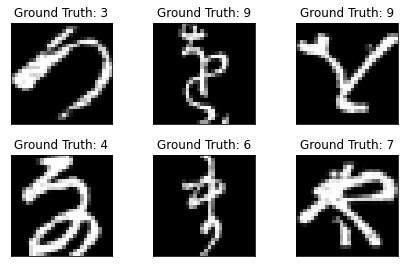

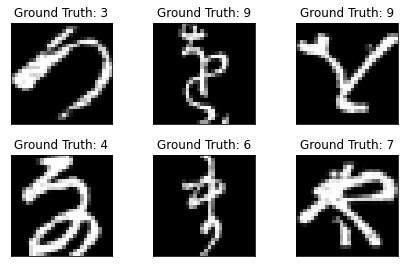

In [94]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0, :, :], cmap='gray', interpolation='none')
    plt.title(f'Ground Truth: {example_targets[i]}')
    plt.xticks([])
    plt.yticks([])
fig

## Check 2: Check Labels

In [95]:
num_classes = 10

In [96]:
train_data.classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

In [97]:
train_class_count = [0 for i in range(num_classes)]
for _, labels_batch in train_loader:
    for label in labels_batch:
        train_class_count[label] += 1

In [98]:
print('Train data:')
for idx, num in enumerate(train_class_count):
    print(f'Label {train_data.classes[idx]}: {num}')

Train data:
Label o: 4496
Label ki: 4471
Label su: 4481
Label tsu: 4572
Label na: 4537
Label ha: 4473
Label ma: 4522
Label ya: 4485
Label re: 4513
Label wo: 4450


In [100]:
val_class_count = [0 for i in range(num_classes)]
for _, labels_batch in val_loader:
    for label in labels_batch:
        val_class_count[label] += 1

In [102]:
print('Validation data:')
for idx, num in enumerate(val_class_count):
    print(f'Label {train_data.classes[idx]}: {num}')

Validation data:
Label o: 1504
Label ki: 1529
Label su: 1519
Label tsu: 1428
Label na: 1463
Label ha: 1527
Label ma: 1478
Label ya: 1515
Label re: 1487
Label wo: 1550


In [103]:
print('All Training data:')
total_sample = 0
for idx, num in enumerate(train_class_count):
    print(f'Label {train_data.classes[idx]}: {num + val_class_count[idx]}')
    total_sample += num + val_class_count[idx]

print()
print(f'Total samples for training data: {total_sample}')

All Training data:
Label o: 6000
Label ki: 6000
Label su: 6000
Label tsu: 6000
Label na: 6000
Label ha: 6000
Label ma: 6000
Label ya: 6000
Label re: 6000
Label wo: 6000

Total samples for training data: 60000


In [105]:
test_class_count = [0 for i in range(num_classes)]
for _, labels_batch in test_loader:
    for label in labels_batch:
        test_class_count[label] += 1

In [106]:
print('Test data:')
total_sample = 0
for idx, num in enumerate(test_class_count):
    print(f'Label {train_data.classes[idx]}: {num}')
    total_sample += num

print()
print(f'Total samples for test data: {total_sample}')

Test data:
Label o: 1000
Label ki: 1000
Label su: 1000
Label tsu: 1000
Label na: 1000
Label ha: 1000
Label ma: 1000
Label ya: 1000
Label re: 1000
Label wo: 1000

Total samples for test data: 10000


## Create Model



In [107]:
# define func to create a model
class MLP(nn.Module):
    def __init__(self, hidden_layer_num, hidden_layer_unit):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_layer_unit)
        
        self.fc_list = nn.ModuleList()
        for i in range(hidden_layer_num):
            if i == 1:
                continue
            if i == hidden_layer_num - 1:
                break
            self.fc_list.append(nn.Linear(hidden_layer_unit, hidden_layer_unit))
        
        self.fc_last = nn.Linear(hidden_layer_unit, 10)

    def forward(self, x):
        # flatten all dimensions except the batch dimension
        x = x.view(x.shape[0],-1)  
        x = F.relu(self.fc1(x))
        
        for fc in self.fc_list:
            x = F.relu(fc(x))
        
        x = self.fc_last(x)
        return x

In [108]:
torch.cuda.is_available()

True

In [109]:
# define func to create model + criterion and chosen optimizer
def create_model(hidden_layer_num, hidden_layer_unit, optimizer_name):
    model = MLP(hidden_layer_num=hidden_layer_num, hidden_layer_unit=hidden_layer_unit)
    if torch.cuda.is_available():
        model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return model, criterion, optimizer

In [110]:
# sample model
create_model(2, 256, 'SGD')

(MLP(
   (fc1): Linear(in_features=784, out_features=256, bias=True)
   (fc_list): ModuleList(
     (0): Linear(in_features=256, out_features=256, bias=True)
   )
   (fc_last): Linear(in_features=256, out_features=10, bias=True)
 ), CrossEntropyLoss(), SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [ ]:
def train_kmnist(config):
    num_epoch = 5
    log_interval = 200
    
    print(config)
    model, criterion, optimizer = create_model(config['hidden_layer_num'], 
                                               config['hidden_layer_unit'], 
                                               config['optimizer_name'])

    train_losses_minibatches = []
    train_losses_epoch = []
    val_losses = []
    
    
    for epoch in range(num_epoch):
        model.train()
        epoch_losses = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
            train_losses_minibatches.append(loss.item())
            epoch_losses += loss.item()

            # if batch_idx % log_interval == 0:
            #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #         epoch, batch_idx * len(data), len(train_loader.dataset),
            #         100. * batch_idx / len(train_loader), loss.item()))
                
        train_losses_epoch.append(epoch_losses)
        
        # check in validation set
        
        model.eval()
        val_loss = 0
        correct_train = 0
        correct_val = 0
        with torch.no_grad():
            # calculate accuracy on train set
            for data, target in train_loader:
                if torch.cuda.is_available():
                   data, target = data.cuda(), target.cuda()

                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct_train += pred.eq(target.data.view_as(pred)).sum()


            # calculate accuracy on valdiation set
            for data, target in val_loader:
                if torch.cuda.is_available():
                   data, target = data.cuda(), target.cuda()

                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct_val += pred.eq(target.data.view_as(pred)).sum()

            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

            # print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            #     val_loss, correct, len(val_loader.dataset),
            #     100. * correct / len(val_loader.dataset)))
            
            tune.report(train_accuracy=100. * correct_train.item() / len(train_loader.dataset), val_accuracy=100. * correct_val.item() / len(val_loader.dataset))

## Hyperparameter Tuning

In [ ]:
%%time
analysis = tune.run(
    train_kmnist, config={
        'hidden_layer_num': tune.grid_search([1, 3, 5]),
        'hidden_layer_unit': tune.grid_search([128, 256]),
        'optimizer_name': tune.grid_search(['SGD', 'Adam'])
        }, resources_per_trial={'gpu': 1}, verbose=0)

2022-05-25 14:25:42,695	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00000
2022-05-25 14:25:43,538	WARNING worker.py:1382 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-05-25 14:25:43,769	WARNING util.py:171 -- The `start_trial` operation took 1.069 s, which may be a performance bottleneck.


(train_kmnist pid=3533) {'hidden_layer_num': 1, 'hidden_layer_unit': 128, 'optimizer_name': 'SGD'}


2022-05-25 14:26:43,859	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00001


(train_kmnist pid=3597) {'hidden_layer_num': 3, 'hidden_layer_unit': 128, 'optimizer_name': 'SGD'}


2022-05-25 14:27:45,871	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00002


(train_kmnist pid=3660) {'hidden_layer_num': 5, 'hidden_layer_unit': 128, 'optimizer_name': 'SGD'}


2022-05-25 14:28:51,880	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00003


(train_kmnist pid=3724) {'hidden_layer_num': 1, 'hidden_layer_unit': 256, 'optimizer_name': 'SGD'}


2022-05-25 14:29:52,915	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00004


(train_kmnist pid=3787) {'hidden_layer_num': 3, 'hidden_layer_unit': 256, 'optimizer_name': 'SGD'}


2022-05-25 14:30:54,922	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00005


(train_kmnist pid=3851) {'hidden_layer_num': 5, 'hidden_layer_unit': 256, 'optimizer_name': 'SGD'}


2022-05-25 14:32:01,935	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00006


(train_kmnist pid=3915) {'hidden_layer_num': 1, 'hidden_layer_unit': 128, 'optimizer_name': 'Adam'}


2022-05-25 14:33:03,943	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00007


(train_kmnist pid=3980) {'hidden_layer_num': 3, 'hidden_layer_unit': 128, 'optimizer_name': 'Adam'}


2022-05-25 14:34:08,951	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00008


(train_kmnist pid=4045) {'hidden_layer_num': 5, 'hidden_layer_unit': 128, 'optimizer_name': 'Adam'}


2022-05-25 14:35:19,964	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00009


(train_kmnist pid=4111) {'hidden_layer_num': 1, 'hidden_layer_unit': 256, 'optimizer_name': 'Adam'}


2022-05-25 14:36:22,971	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00010


(train_kmnist pid=4174) {'hidden_layer_num': 3, 'hidden_layer_unit': 256, 'optimizer_name': 'Adam'}


2022-05-25 14:37:28,981	INFO trial_runner.py:803 -- starting train_kmnist_8b2e4_00011


(train_kmnist pid=4240) {'hidden_layer_num': 5, 'hidden_layer_unit': 256, 'optimizer_name': 'Adam'}
CPU times: user 17.7 s, sys: 3.72 s, total: 21.4 s
Wall time: 13min 5s


In [ ]:
df = analysis.dataframe()
df.head()

,train_accuracy,val_accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,...,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,config/hidden_layer_num,config/hidden_layer_unit,config/optimizer_name,logdir
0,87.537778,86.746667,10.553428,False,NaN,NaN,5,8b2e4_00000,eedba981e29f4716a8eb44ee5856bd85,2022-05-25_14-26-43,...,db5fb9aa6cd6,172.28.0.2,57.056912,0,5,0.003110,1,128,SGD,/root/ray_results/train_kmnist_2022-05-25_14-2...
1,88.702222,87.666667,10.937069,False,NaN,NaN,5,8b2e4_00001,f60a9dede90a44d6b4e92b05797b2829,2022-05-25_14-27-45,...,db5fb9aa6cd6,172.28.0.2,58.504091,0,5,0.003701,3,128,SGD,/root/ray_results/train_kmnist_2022-05-25_14-2...
2,86.448889,85.433333,12.229949,False,NaN,NaN,5,8b2e4_00002,f0260a4d816b407b96c3516f6ca97c3b,2022-05-25_14-28-51,...,db5fb9aa6cd6,172.28.0.2,62.853097,0,5,0.003448,5,128,SGD,/root/ray_results/train_kmnist_2022-05-25_14-2...
3,87.973333,87.153333,10.727961,False,NaN,NaN,5,8b2e4_00003,e17ca02638af4d1c8a758b8361ccc36d,2022-05-25_14-29-52,...,db5fb9aa6cd6,172.28.0.2,57.559098,0,5,0.003723,1,256,SGD,/root/ray_results/train_kmnist_2022-05-25_14-2...
4,88.642222,87.766667,11.017715,False,NaN,NaN,5,8b2e4_00004,4ab53ff543954d1bab215077260c1ec9,2022-05-25_14-30-54,...,db5fb9aa6cd6,172.28.0.2,58.826188,0,5,0.003186,3,256,SGD,/root/ray_results/train_kmnist_2022-05-25_14-2...


In [ ]:
df.columns

Index(['train_accuracy', 'val_accuracy', 'time_this_iter_s', 'done',
       'timesteps_total', 'episodes_total', 'training_iteration', 'trial_id',
       'experiment_id', 'date', 'timestamp', 'time_total_s', 'pid', 'hostname',
       'node_ip', 'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'warmup_time', 'config/hidden_layer_num',
       'config/hidden_layer_unit', 'config/optimizer_name', 'logdir'],
      dtype='object')

In [ ]:
df = df[['config/hidden_layer_num', 'config/hidden_layer_unit', 'config/optimizer_name', 'train_accuracy', 'val_accuracy', 'time_total_s']]

In [ ]:
df = df.sort_values('val_accuracy', ascending=False)
df

,config/hidden_layer_num,config/hidden_layer_unit,config/optimizer_name,train_accuracy,val_accuracy,time_total_s
10,3,256,Adam,98.926667,95.573333,62.987633
11,5,256,Adam,98.477778,95.566667,68.844087
9,1,256,Adam,98.673333,95.186667,59.716369
7,3,128,Adam,98.404444,94.906667,61.949591
6,1,128,Adam,98.160000,94.860000,58.703691
8,5,128,Adam,97.711111,94.466667,67.720645
5,5,256,SGD,89.253333,88.420000,63.310016
4,3,256,SGD,88.642222,87.766667,58.826188
1,3,128,SGD,88.702222,87.666667,58.504091
3,1,256,SGD,87.973333,87.153333,57.559098


In [ ]:
df.rename(columns = {'config/hidden_layer_num':'hidden_layer_number', 
                      'config/hidden_layer_unit':'hidden unit per layer',
                      'config/optimizer_name': 'optimizer',
                      'time_total_s': 'training time (s)'
                      }, inplace=True)

In [ ]:
df['epoch'] = 5
df['minibacth_size'] = 32
df['training_size'] = 45000
df['validation_size'] = 15000

df['learning_rate'] = df['optimizer'].apply(lambda x: 0.01 if x=='SGD' else 0.001)

In [ ]:
df

,hidden_layer_number,hidden unit per layer,optimizer,train_accuracy,val_accuracy,training time (s),epoch,minibacth_size,training_size,validation_size,learning_rate
10,3,256,Adam,98.926667,95.573333,62.987633,5,32,45000,15000,0.001
11,5,256,Adam,98.477778,95.566667,68.844087,5,32,45000,15000,0.001
9,1,256,Adam,98.673333,95.186667,59.716369,5,32,45000,15000,0.001
7,3,128,Adam,98.404444,94.906667,61.949591,5,32,45000,15000,0.001
6,1,128,Adam,98.160000,94.860000,58.703691,5,32,45000,15000,0.001
8,5,128,Adam,97.711111,94.466667,67.720645,5,32,45000,15000,0.001
5,5,256,SGD,89.253333,88.420000,63.310016,5,32,45000,15000,0.010
4,3,256,SGD,88.642222,87.766667,58.826188,5,32,45000,15000,0.010
1,3,128,SGD,88.702222,87.666667,58.504091,5,32,45000,15000,0.010
3,1,256,SGD,87.973333,87.153333,57.559098,5,32,45000,15000,0.010


## Train Model with selected Hyperparameters

In [111]:
model, criterion, optimizer = create_model(3, 256, 'Adam')

In [112]:
max_num_epoch = 10
log_interval = 200

train_losses_minibatches = []
train_losses_epoch = []
val_losses = []

train_accuracy = []
val_accuracy = []

lowest_val_error = sys.maxsize
patience = 2

In [113]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
        train_losses_minibatches.append(loss.item())

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [114]:
def evaluate():
    model.eval()
    val_loss = 0
    train_loss = 0
    correct_train = 0
    correct_val = 0
    with torch.no_grad():
          # calculate accuracy on train set
          for data, target in train_loader:
              if torch.cuda.is_available():
                  data, target = data.cuda(), target.cuda()

              output = model(data)
              train_loss += criterion(output, target).item()
              pred = output.data.max(1, keepdim=True)[1]
              correct_train += pred.eq(target.data.view_as(pred)).sum()

          train_loss /= len(train_loader.dataset)
          train_losses_epoch.append(train_loss)
          train_accuracy.append(100. * correct_train.item() / len(train_loader.dataset))

          # calculate accuracy on valdiation set
          for data, target in val_loader:
              if torch.cuda.is_available():
                  data, target = data.cuda(), target.cuda()

              output = model(data)
              val_loss += criterion(output, target).item()
              pred = output.data.max(1, keepdim=True)[1]
              correct_val += pred.eq(target.data.view_as(pred)).sum()

          val_loss /= len(val_loader.dataset)
          val_losses.append(val_loss)
          val_accuracy.append(100. * correct_val.item() / len(val_loader.dataset))

          print('Training set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
              train_loss, correct_train, len(train_loader.dataset),
              100. * correct_train.item() / len(train_loader.dataset)))
          print('Validation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
              val_loss, correct_val, len(val_loader.dataset),
              100. * correct_val.item() / len(val_loader.dataset)))
      
    return val_loss

In [115]:
no_improve_counter = 0
evaluate()
for epoch in range(max_num_epoch):
    train(epoch)
    loss = evaluate()
    if loss <= lowest_val_error:
        lowest_val_error = loss
        no_improve_counter = 0
    else:
        no_improve_counter += 1
    
    if no_improve_counter >= patience:
        print(f'Early stopping at epoch: {epoch} because no decrement in the validation loss.')
        break

Training set: Avg. loss: 0.0719, Accuracy: 6238/45000 (14%)
Validation set: Avg. loss: 0.0719, Accuracy: 1976/15000 (13%)

Train Epoch: 0 [0/45000 (0%)]	Loss: 2.314587
Train Epoch: 0 [6400/45000 (14%)]	Loss: 0.694074
Train Epoch: 0 [12800/45000 (28%)]	Loss: 0.619816
Train Epoch: 0 [19200/45000 (43%)]	Loss: 0.199498
Train Epoch: 0 [25600/45000 (57%)]	Loss: 0.616423
Train Epoch: 0 [32000/45000 (71%)]	Loss: 0.190123
Train Epoch: 0 [38400/45000 (85%)]	Loss: 0.254990
Train Epoch: 0 [44800/45000 (100%)]	Loss: 0.045270
Training set: Avg. loss: 0.0067, Accuracy: 42082/45000 (94%)
Validation set: Avg. loss: 0.0084, Accuracy: 13801/15000 (92%)

Train Epoch: 1 [0/45000 (0%)]	Loss: 0.328646
Train Epoch: 1 [6400/45000 (14%)]	Loss: 0.154558
Train Epoch: 1 [12800/45000 (28%)]	Loss: 0.235181
Train Epoch: 1 [19200/45000 (43%)]	Loss: 0.088306
Train Epoch: 1 [25600/45000 (57%)]	Loss: 0.058591
Train Epoch: 1 [32000/45000 (71%)]	Loss: 0.133241
Train Epoch: 1 [38400/45000 (85%)]	Loss: 0.328430
Train Epoch: 

### Losses of every minibatches


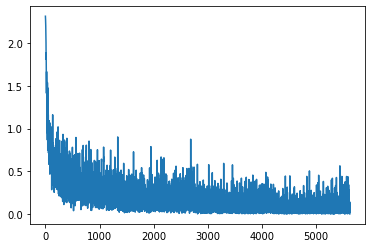

In [116]:
plt.plot(train_losses_minibatches)

### Losses of every epoch

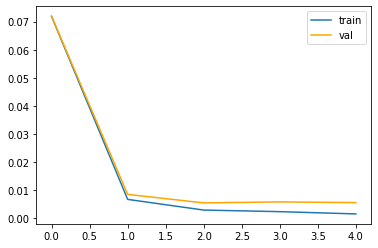

In [117]:
plt.plot(train_losses_epoch)
plt.plot(val_losses, color='orange')
plt.legend(['train', 'val'])

### Accuracy after of every epoch

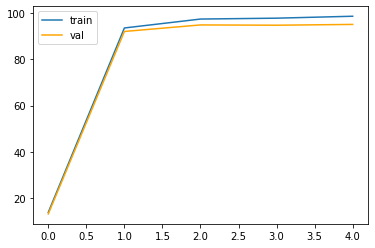

In [118]:
plt.plot(train_accuracy)
plt.plot(val_accuracy, color='orange')
plt.legend(['train', 'val'])

### Accuracy on Test Set

In [ ]:
model.eval()
test_loss = 0
correct_test = 0

with torch.no_grad():
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct_test += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)

    print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct_test, len(test_loader.dataset),
        100. * correct_test.item() / len(test_loader.dataset)))

Test set: Avg. loss: 0.0143, Accuracy: 8918/10000 (89%)


# Task 2

In [ ]:
def compute_probability_dist(dataset):
    dataset_np = dataset.data.numpy()
    dataset_np = np.reshape(dataset_np, (-1, 28*28))

    pixel_proba = np.array([[0. for j in range(256)] for i in range(28*28)])
    
    for i in range(28*28):
        pixel_i = dataset_np[:, i]
        unique_count = np.unique(pixel_i, return_counts=True)

        for idx, value in enumerate(unique_count[0]):
            pixel_proba[i][value] = unique_count[1][idx]/len(dataset_np)

    return pixel_proba


### Q1 Probability on Training Data

In [ ]:
train_pixel_proba = compute_probability_dist(train_data)

In [ ]:
# peek into the pixel probability array
train_pixel_proba[0][:20]

array([9.94100000e-01, 5.00000000e-04, 2.66666667e-04, 2.83333333e-04,
       1.50000000e-04, 1.66666667e-04, 1.83333333e-04, 1.00000000e-04,
       5.00000000e-05, 1.00000000e-04, 1.00000000e-04, 6.66666667e-05,
       5.00000000e-05, 1.33333333e-04, 1.33333333e-04, 3.33333333e-05,
       8.33333333e-05, 8.33333333e-05, 6.66666667e-05, 3.33333333e-05])

### Q2 Probability on Test Data

In [ ]:
test_pixel_proba = compute_probability_dist(test_data)

In [ ]:
# peek into the pixel probability array
test_pixel_proba[0][:20]

array([9.949e-01, 3.000e-04, 1.000e-04, 1.000e-04, 2.000e-04, 2.000e-04,
       3.000e-04, 1.000e-04, 3.000e-04, 1.000e-04, 2.000e-04, 1.000e-04,
       1.000e-04, 2.000e-04, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00,
       2.000e-04, 0.000e+00])

### Q3 Visualize probability for pixel #123

In [ ]:
# make sure that the total of proba is 1
print(train_pixel_proba[123].sum())
print(test_pixel_proba[123].sum())

1.0000000000000002
0.9999999999999998


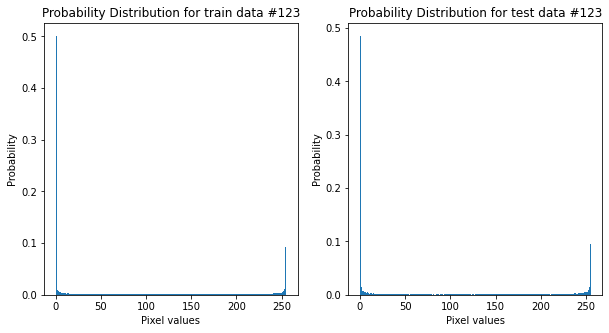

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(x=[i for i in range(256)], bins=256, weights=train_pixel_proba[123]);
ax1.set_title('Probability Distribution for train data #123')
ax1.set_xlabel("Pixel values")
ax1.set_ylabel("Probability")

ax2.hist(x=[i for i in range(256)], bins=256, weights=test_pixel_proba[123]);
ax2.set_title('Probability Distribution for test data #123')
ax2.set_xlabel("Pixel values")
ax2.set_ylabel("Probability");

### Q4a Compute the Shannon Entropy

In [ ]:
def shannon_log(x):
    return -1 * x * math.log(x, 2)

In [ ]:
def compute_entropy(probability_dist):
    entropies = []

    for proba in probability_dist:
        entropy = [shannon_log(x) for x in proba if x>0]
        entropies.append(sum(entropy))

    total_entropy = sum(entropies)

    return np.array(entropies), total_entropy

In [ ]:
train_entropy_list, train_total_entropy = compute_entropy(train_pixel_proba)
print(f'Entropy for train data H(x): {train_total_entropy}')

Entropy for train data H(x): 2447.150658798105


In [ ]:
test_entropy_list, test_total_entropy = compute_entropy(test_pixel_proba)
print(f'Entropy for test data H(x): {test_total_entropy}')

Entropy for test data H(x): 2407.1840029090063


In [ ]:
print(train_entropy_list.shape)
train_entropy_list[:20]

(784,)


array([0.0895588 , 0.16458159, 0.26130604, 0.39351536, 0.59963562,
       0.87885991, 1.23728993, 1.62892182, 2.03865259, 2.43851124,
       2.825307  , 3.20288528, 3.4651016 , 3.55357147, 3.41686392,
       3.07092999, 2.54436874, 1.99952839, 1.60492879, 1.32814015])

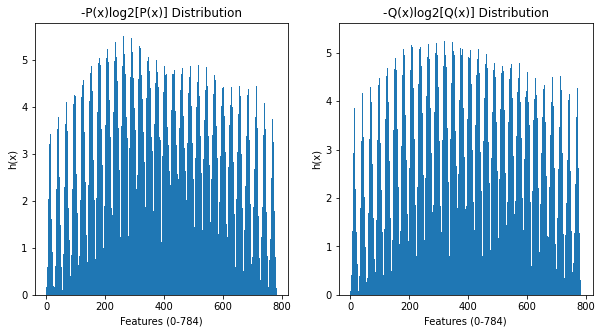

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(x=[i for i in range(784)], bins=784, weights=train_entropy_list);
ax1.set_title('-P(x)log2[P(x)] Distribution')
ax1.set_xlabel("Features (0-784)")
ax1.set_ylabel("h(x)")

ax2.hist(x=[i for i in range(784)], bins=784, weights=test_entropy_list);
ax2.set_title('-Q(x)log2[Q(x)] Distribution')
ax2.set_xlabel("Features (0-784)")
ax2.set_ylabel("h(x)");

### Q4b What is the best way to measure the difference between entropy of training vs test dataset that you have computed?

The best way to measure the difference between entropy of training vs test dataset is by compute the total entropy of each feature and compared it between the train and test set. After we get a table of differences between each feature, we could evaluate between the most and the least important feature in the dataset.

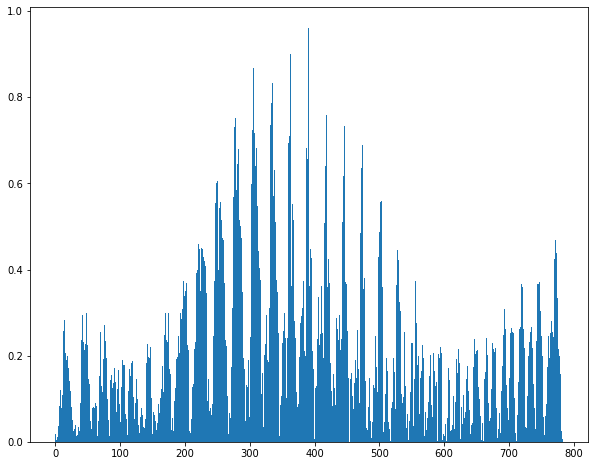

In [ ]:
plt.figure(figsize=(10,8))
entropy_diff = np.array(abs(train_entropy_list-test_entropy_list))
plt.hist(x=[i for i in range(784)], bins=784, weights=entropy_diff);

In [ ]:
top_20_entropy_diff = np.argsort(-entropy_diff)[:20]
print(f'Features with the highest amount of difference in entropy: {top_20_entropy_diff+1}')

Features with the highest amount of difference in entropy: [392 420 364 448 307 335 336 363 306 334 391 278 419 476 279 333 447 277
 305 308]


In [ ]:
bottom_20_entropy_diff = np.argsort(entropy_diff)[:20]
print(f'Features with the lowest amount of difference in entropy: {bottom_20_entropy_diff+1}')

Features with the lowest amount of difference in entropy: [700 455 713 518 454 662 136   3 591 605 659 728 546 182 599   2 618 612
 401  34]


We can see that feature #392 has the highest amount of difference in entropy. This means that this particular feature contribute the most in identifying the label.

We also could see that all the top features are located at the centre of the image while bottom features otherwise.